<a href="https://colab.research.google.com/github/apchavezr/16.-Aprendizaje-Profundo-para-Ciencia-de-Datos/blob/main/LSTM_Serie_Temporal_USDCOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de series temporales con LSTM

## Introducción al problema
Este ejercicio tiene como objetivo construir un modelo de red neuronal recurrente tipo LSTM para predecir el precio del dólar al día siguiente, a partir de datos históricos. Las redes LSTM son una variante de las RNN diseñadas para capturar patrones de largo plazo en secuencias, lo que las hace adecuadas para tareas de predicción en series temporales financieras como esta.

Se utilizarán datos históricos del tipo de cambio USD/COP obtenidos a través de Yahoo Finance.


## Carga y preprocesamiento de datos

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


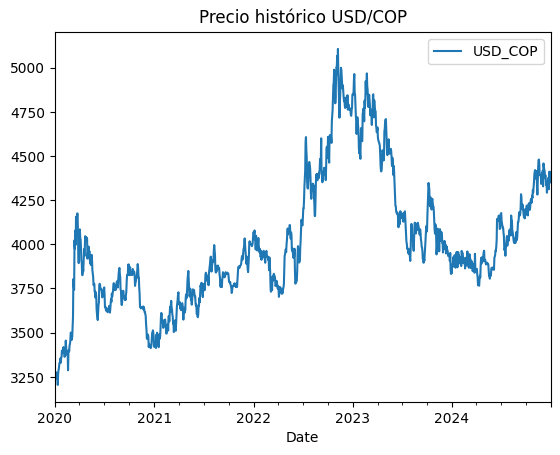

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Descargar datos históricos del dólar
df = yf.download('USDCOP=X', start='2020-01-01', end='2024-12-31')
df = df[['Close']].dropna()
df.columns = ['USD_COP']

# Visualizar los datos
df.plot(title='Precio histórico USD/COP')
plt.show()

# Escalar los datos entre 0 y 1
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Crear secuencias para entrenamiento
def crear_secuencias(data, pasos):
    X, y = [], []
    for i in range(pasos, len(data)):
        X.append(data[i - pasos:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

pasos = 30
X, y = crear_secuencias(df_scaled, pasos)

# Redimensionar para entrada a LSTM [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir entre entrenamiento y prueba
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


## Definición y entrenamiento del modelo

In [2]:
# Definir modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(pasos, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0870 - val_loss: 0.0023
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_loss: 9.2605e-04
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 11/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - val_loss: 9.0380e-04
Epoch 12/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013

## Evaluación del rendimiento

In [3]:
# Evaluar error cuadrático medio
loss = model.evaluate(X_test, y_test)
print(f"Error cuadrático medio en prueba: {loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8188e-04
Error cuadrático medio en prueba: 0.0004


El resultado obtenido fue un MSE de 0.0004, lo cual indica una diferencia muy baja entre las predicciones realizadas por el modelo y el valor real del precio del dólar (USD/COP). Este valor es consistente con un modelo que ha logrado aprender con precisión los patrones históricos de la serie temporal.

La ejecución del proceso de evaluación también muestra una eficiencia computacional alta, dado que la operación se completó en aproximadamente 0.01 segundos por paso, lo que sugiere que el modelo es viable para aplicaciones en tiempo real o en entornos donde se requiere inferencia rápida.

## Análisis e interpretación de resultados

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


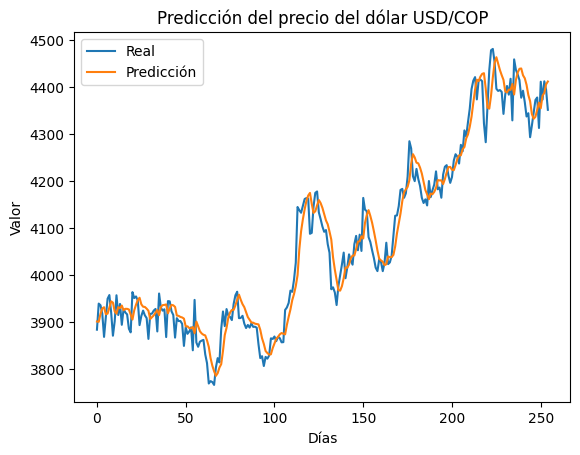

In [4]:
# Predicciones
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Gráfica de comparación
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Predicción')
plt.title('Predicción del precio del dólar USD/COP')
plt.xlabel('Días')
plt.ylabel('Valor')
plt.legend()
plt.show()


La imagen demuestra que el modelo LSTM no solo ofrece una baja magnitud de error (como lo evidencia el MSE de 0.0004 previamente reportado), sino que también logra reproducir fielmente el comportamiento del mercado cambiario en el tiempo. Esto refuerza su utilidad como herramienta de pronóstico en contextos financieros, especialmente cuando se requieren estimaciones consistentes a corto plazo.